#**Dynamic Programming - Mine Management**



In this notebook we will use dynamic programming to solve
a mine management problem in the view of a firm which
wants to maximize its profits. First we apply
**policy evaluation** and then use **policy iteration** to
find an optimal policy. In the end we will use the
**value iteration** algorithm to solve the same problem again.


![Photo by Alan Thomas from Pexels](https://drive.google.com/uc?id=1WdyHafa0mBUXE-2Q5tpeuBLMU4s7Smqg) (Photo by Alan Thomas from Pexels)


A mine operator must decide how much ore to extract from a mine.
The market price of extracted ore is $p$ dollars per ton,
and the total cost of extracting $a$ tons of ore in any year,
given that the mine contains $s$ tons, is $c(s, a)$.

The market price $p = 1$, the initial stock of ore is 100,
cost of extraction is $c(s, a) = a^2/(1+s)$,
and annual discount factor $\gamma = 0.9$.





# **Model**


The units of ore $s$ is a discrete state variable:
- $s \in \{0, 1, 2, \dots, 100\}$


The action variable $a$ is the amount of ore extracted:
- $a \in \{0, 1, 2, \dots, s\}$

The state transition function is:
- $t(s, a) = s - a$

The reward function is:
- $r(s, a) = p\cdot a - a^2/(1+s)$

# Environment

We are using Open AI Gym to create our environments. 

The Gym interface of an environment is described
in [https://stable-baselines.readthedocs.io/en/master/guide/custom_env.html](https://stable-baselines.readthedocs.io/en/master/guide/custom_env.html).

Next you will implement the mine management environment with the
Open AI Gym framework, but first import all the necessary libraries
for this notebook.

In [1]:
import gym
from gym import spaces

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

The structure of the gym environment is given. You have to implement the state transistion only.

In [2]:
class MineManagementEnv(gym.Env):
    """Custom Environment that follows gym interface."""
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(MineManagementEnv, self).__init__()
        # Define action and observation space
        # They must be gym.spaces objects
        # Example when using discrete actions:
        n_actions = 101
        self.action_space = spaces.Discrete(n_actions)

        # With spaces.Tuple you can create a multidimensional state
        # In our simple model observation and state are synonyms
        self.initial_ore = 100
        self.observation_space = spaces.Discrete(self.initial_ore+1)

        self.price = 1
        
        
    def step(self, action):
        """State transition of the model.

        Args:
            action (int): Amount of extracted ore

        Returns:
            state (numpy.ndarray): A shape-() array
            reward (int): Reward signal, which is here the profit
            done (bool): Indicating if terminal state is reached
            info (dict): Infos for debugging

        """

        assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))
        assert action <= self.state, "%r is to much extraction" % action


        reward = self.profit(self.state, action)

        # state transition
        self.state -= action

        # This is a episodic task, so done is true if the mine is empty
        done = self.state == 0

        info = {}

        return np.array(self.state), reward, done, info


    def profit(self, state, action):
        """Calculates the profit of extracted ore
        
        Args:
            state (int): Current state, i.e. amount of ore
            action (int): Amount of extracted ore

        Returns:
            profit (int): Profit of extracted ore
        """

        return self.price*action - action**2/(1+state)
        

    def reset(self):
        """Resets the environment

        Initializes the state variable

        Returns:
            state (numpy.ndarray): A shape-() array
        
        """
        self.state = self.initial_ore
                      
        return np.array(self.state)


    # We will not implement render and close function
    def render(self, mode='human'):
        pass
    def close (self):
        pass


---


**Let's test our environment**


---


 You can find the basic structure to simulate the environment in the [Open AI documentation](https://gym.openai.com/docs/). 
 
Basically there are just 5 steps necessary, (see next cell).

Here we will use a simple policy to simulate the episode. 

Later in this notebook we will implement algorithms which learn good policies.



In [3]:
# 1st step: create the environment
env = MineManagementEnv()

# 2nd step: reset the environment
# here we save the initial state for the plot later
state = env.reset()


state_path = [state]

# 3rd step: loop over each time step in the episode
done = False
while not done:
    # 4th step: determine the action
    action = min(10, state)

    # 5th step: move to the next time step given action
    state, reward, done, _ = env.step(action)
    
    state_path.append(state)



---

**Plot the episode**


---



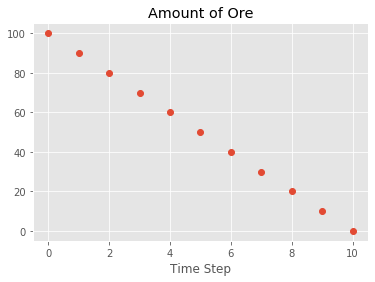

In [4]:
fig, ax = plt.subplots()

ax.set_xlabel('Time Step')
ax.set_title('Amount of Ore')

ax.plot(state_path, 'o');

# **Policy Evaluation**

Let's evaluate this policy using the policy evaluation algorithm. Let's write a function which implements the policy evaluation algorithm.

In [5]:
def evaluate_policy(env, V, policy, gamma, eps=1e-8, max_iter=1000):
    """Implements the policy evaluation algorithm
    
    Calculates the corresponding value function of a policy

    Args:
        env (class): MineManagement Environment
        V (numpy.ndarray): A shape-(num_states,) array, contains the value for
            every state
        policy (numpy.ndarray): A shape-(num_states,) array, defines the action
            for every state
        gamma (float): Discount factor
        eps (float): Error tolerance for stopping the iteration
        max_iter (int): Maximum number of iteration if process doesn't converge

    Returns:
        V (numpy.ndarray): A shape-(num_states,) array, contains the value for
            every state
    
    """

    n_states = env.observation_space.n


    for i in range(max_iter):
        # save value function to check for convergence later
        V_old = V.copy()

        # one iteration step for all states
        V = env.profit(np.arange(n_states), policy) + gamma*V[np.arange(n_states) - policy]

        # check for convergence
        delta = np.linalg.norm(V-V_old)
        if delta < eps:
            break
    
    return V   


In [6]:
# create environment and reset it
env = MineManagementEnv()
env.reset()

# define policy to evaluate, i.e. always extract a if possible, else everything
a = 10
policy = np.minimum(np.arange(env.observation_space.n), a)    

# init value function
V = np.zeros(env.observation_space.n)

# discount factor
gamma = 0.9

# evaluate policy
V = evaluate_policy(env, V, policy, gamma)



---

**Plot the value function**


---



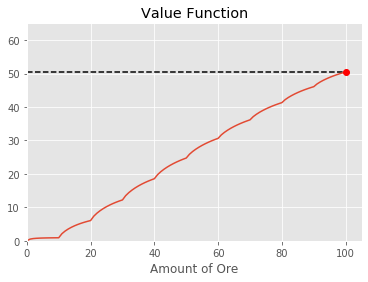

In [7]:
fig, ax = plt.subplots()

ax.set_xlabel('Amount of Ore')
ax.set_title('Value Function')

ax.set_xlim(0, 105)
ax.set_ylim(0, 65)


ax.plot(V)
ax.plot(len(V)-1, V[-1], 'ro')
ax.hlines(V[-1], 0, len(V), colors='k', linestyles='dashed');

The cumulative discounted profit is about 50.5 if every period an amount of 10 ore is extracted. 

# **Policy Iteration**

First we implement the policy improvement algorithm to combine it later with the policy evaluation algorithm to create the policy iteration algorithm.

In [8]:
def improve_policy(env, V, policy, gamma):
    """Implements the policy improvement algorithm

    Calculates the greedy policy for a given value function and checks if the 
    new greedy policy changed compared to the old policy

    Args:
        env (class): OpenAI gym environment
        V (numpy.ndarray): A shape-(num_states,) array, contains the value for
            every state
        policy (numpy.ndarray): A shape-(num_states,) array, defines the action
            for every state
        gamma (int): Discount factor
    """

    # save policy to check for convergence later
    old_policy = policy.copy()

    # loop through every state and find greedy action
    policy_stable = True
    for i in range(len(policy)):
        # determine possible actions for given state
        possible_actions = np.array([a for a in range(i+1)])

        # find greedy action among possible actions
        policy[i] = np.argmax(env.profit(i, possible_actions) + gamma * V[i-possible_actions])
    
    # check for convergence
    if not np.array_equal(policy, old_policy):
        policy_stable = False
    
    return policy, policy_stable


Combine *evaluate_policy* and *improve_policy* to *policy_iteration*.

In [9]:
def policy_iteration(env, gamma, eps=1e-8, max_iter=1):
    """Implements the policy iteration algorithm

    Calculates the optimal policy and optimal value function

    Args:
        env (class): OpenAI gym environment
        gamma (int): Discount factor
        eps (float): Error tolerance for stopping the iteration inside of 
            policy evaluation
        max_iter (int): Maximum number of iteration inside policy evaluation
    """
    n_states = env.observation_space.n
    
    # init policy and value function
    policy = np.minimum(np.arange(n_states), 1)
    V = np.zeros(n_states)

    # iterate until policy doesn't change anymore
    policy_stable = False
    while not policy_stable:
        V = evaluate_policy(env, V, policy, gamma, eps, max_iter)
        policy, policy_stable = improve_policy(env, V, policy, gamma)

    return V, policy

In [10]:
# create environment and reset it
env = MineManagementEnv()
env.reset()

# discount factor
gamma = 0.9

# apply policy iteration
V, policy = policy_iteration(env, gamma)




---

**Plot the value function and policy function**


---


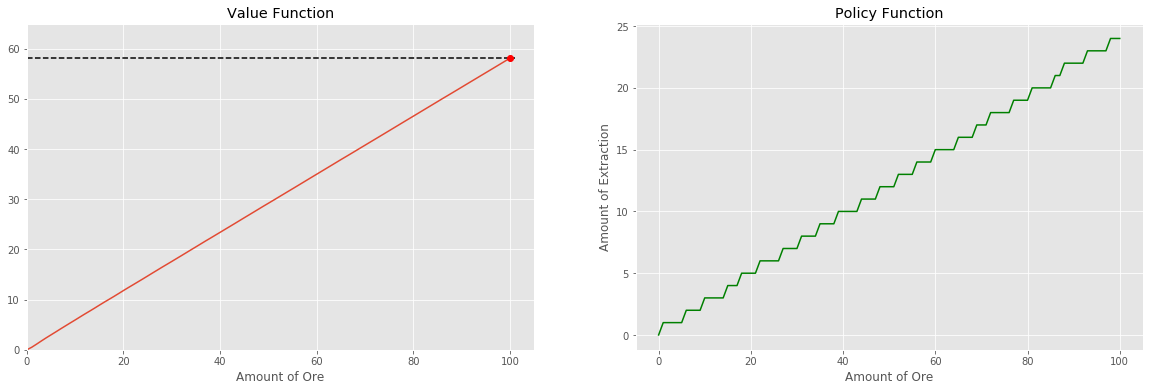

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# plot value function
ax[0].set_xlabel('Amount of Ore')
ax[0].set_title('Value Function')

ax[0].set_xlim(0, 105)
ax[0].set_ylim(0, 65)

ax[0].plot(V);
ax[0].plot(len(V)-1, V[-1], 'ro');
ax[0].hlines(V[-1], 0, len(V), colors='k', linestyles='dashed');

# plot policy function
ax[1].set_xlabel('Amount of Ore')
ax[1].set_ylabel('Amount of Extraction')
ax[1].set_title('Policy Function')

ax[1].plot(policy, 'g-');


# **Value Iteration**

Let's implement the value iteration algorithm. 

In [12]:
def value_iteration(env, gamma, eps=1e-8, max_iter=1000):
    """Implements the value iteration algorithm

    Calculates the optimal policy and optimal value function

    Args:
        env (class): OpenAI gym environment
        gamma (int): Discount factor
        eps (float): Error tolerance
        max_iter (int): Maximum number of iteration
    """
    n_states = env.observation_space.n

    # initialize value function
    V = np.zeros(n_states)

    # iterate until value function converges
    for _ in range(max_iter):
        V_old = V.copy()
        for state in range(len(V)):
            possible_actions = np.array([a for a in range(state+1)])
            V[state] = np.max(env.profit(state, possible_actions) + gamma * V[state-possible_actions])
        delta = np.linalg.norm(V-V_old)
        if delta < eps:
            break

    policy = np.zeros(n_states, dtype=np.int8)
    for state in range(n_states):
        possible_actions = np.array([a for a in range(state+1)])
        policy[state] = np.argmax(env.profit(state, possible_actions) + gamma * V[state-possible_actions])

    return V, policy



In [13]:
# create environment and reset it
env = MineManagementEnv()
env.reset()

# discount factor
gamma = 0.9

# apply policy iteration
V, policy = value_iteration(env, gamma)


---

**Plot the value function and policy function**


---


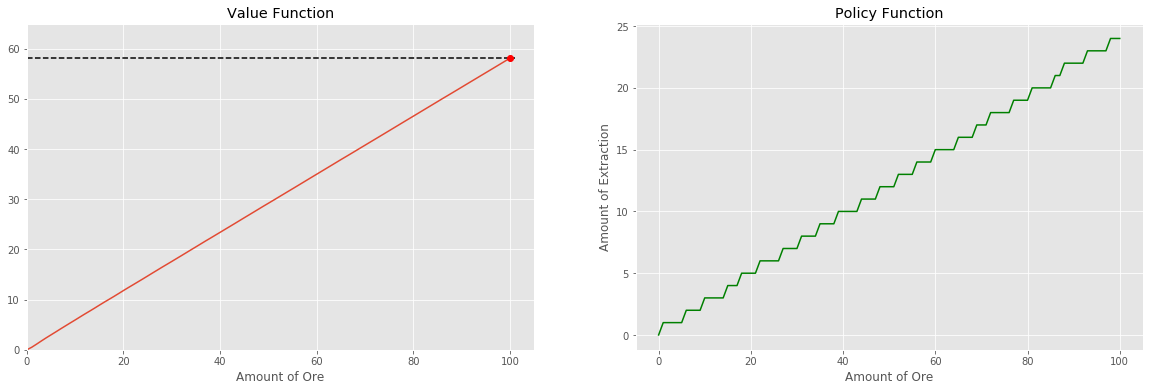

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# plot value function
ax[0].set_xlabel('Amount of Ore')
ax[0].set_title('Value Function')

ax[0].set_xlim(0, 105)
ax[0].set_ylim(0, 65)

ax[0].plot(V);
ax[0].plot(len(V)-1, V[-1], 'ro');
ax[0].hlines(V[-1], 0, len(V), colors='k', linestyles='dashed');

# plot policy function
ax[1].set_xlabel('Amount of Ore')
ax[1].set_ylabel('Amount of Extraction')
ax[1].set_title('Policy Function')

ax[1].plot(policy, 'g-');

Let's simulate an episode with the optimal policy.

In [15]:
env = MineManagementEnv()

state = env.reset()

state_path = [state]

done = False
while not done:
    action = policy[state]
    state, reward, done, _ = env.step(action)
    
    state_path.append(state)

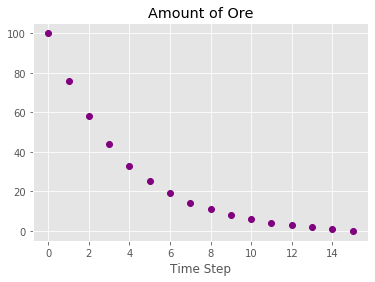

In [16]:
fig, ax = plt.subplots()

ax.set_xlabel('Time Step')
ax.set_title('Amount of Ore')

ax.plot(state_path, 'o', color='purple');